In [1]:
# Standard libraries
import re
import json
import pickle as pkl
import numpy as np
import pandas as pd
from tabulate import tabulate
# RDKit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

### Coronene

#### Load data

In [2]:
# Load data from pickl file
data_file = open('./raw/data_coronene.pkl', 'rb')
data = pkl.load(data_file)

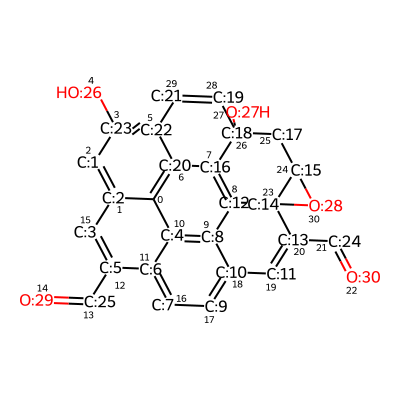

In [3]:
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.6
IPythonConsole.molSize = 400,400
# Show the molecule with RDKit
mol = Chem.MolFromSmiles(data.iloc[0]['SMILES'])
mol

#### View data statistics

In [4]:
atom_df = pd.DataFrame(columns=['SMILES', 'atomic_num', 'degree', 'hybridisation', 'hydrogens', 'aromatic', 'ring'])

for index, row in data.iterrows():
    smiles = row['SMILES']
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        a_num = atom.GetAtomicNum()
        degree = atom.GetDegree()
        if atom.GetHybridization() == Chem.rdchem.HybridizationType.SP:
            hybrid = 'SP'
        elif atom.GetHybridization() == Chem.rdchem.HybridizationType.SP2:
            hybrid = 'SP2'
        elif atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3:
            hybrid = 'SP3'
        hydro = atom.GetTotalNumHs()
        aro = atom.GetIsAromatic()
        ring = atom.IsInRing()
        atom_df = pd.concat([atom_df, pd.DataFrame([[smiles, a_num, degree, hybrid, hydro, aro, ring]], columns=['SMILES', 'atomic_num', 'degree', 'hybridisation', 'hydrogens', 'aromatic', 'ring'])], ignore_index=True)


In [5]:
print('Total number of carbons =', atom_df[atom_df['atomic_num'] == 6]['SMILES'].count())
print('---')
print(atom_df[atom_df['atomic_num'] == 6]['degree'].value_counts())
print('---')
print(atom_df[atom_df['atomic_num'] == 6]['hydrogens'].value_counts())
print('---')
print(atom_df[atom_df['atomic_num'] == 6]['hybridisation'].value_counts())
print('---')
print(atom_df[atom_df['atomic_num'] == 6]['aromatic'].value_counts())
print('---')
print(atom_df[atom_df['atomic_num'] == 6]['ring'].value_counts())

Total number of carbons = 7919
---
degree
3    4575
2    2684
4     660
Name: count, dtype: int64
---
hydrogens
0    4497
1    3136
2     286
Name: count, dtype: int64
---
hybridisation
SP2    6234
SP3    1685
Name: count, dtype: int64
---
aromatic
False    4227
True     3692
Name: count, dtype: int64
---
ring
True     7632
False     287
Name: count, dtype: int64


In [6]:
print(atom_df[atom_df['atomic_num'] == 6].groupby(['degree', 'hydrogens', 'hybridisation', 'aromatic', 'ring']).count())

                                               SMILES  atomic_num
degree hydrogens hybridisation aromatic ring                     
2      0         SP2           True     True        1           1
       1         SP2           False    False     115         115
                                        True     1198        1198
                               True     True     1084        1084
       2         SP3           False    True      286         286
3      0         SP2           False    False     172         172
                                        True     1057        1057
                               True     True     2607        2607
       1         SP3           False    True      739         739
4      0         SP3           False    True      660         660


In [7]:
bond_df = pd.DataFrame(columns=['SMILES', 'bond_type', 'conjugated', 'ring'])

for index, row in data.iterrows():
    smiles = row['SMILES']
    mol = Chem.MolFromSmiles(smiles)
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.SINGLE:
            b_type = 'single'
        elif bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            b_type = 'double'
        elif bond.GetBondType() == Chem.rdchem.BondType.AROMATIC:
            b_type = 'aromatic'
        conj = bond.GetIsConjugated()
        ring = bond.IsInRing()
        bond_df = pd.concat([bond_df, pd.DataFrame([[smiles, b_type, conj, ring]], columns=['SMILES', 'bond_type', 'conjugated', 'ring'])], ignore_index=True)


In [8]:
print('Total number of carbons =', len(bond_df))
print('---')
print(bond_df['bond_type'].value_counts())
print('---')
print(bond_df['conjugated'].value_counts())
print('---')
print(bond_df['ring'].value_counts())
print(' ')
print(bond_df.groupby(['bond_type', 'conjugated', 'ring']).count())

Total number of carbons = 11920
---
bond_type
single      6128
aromatic    4218
double      1574
Name: count, dtype: int64
---
conjugated
True     7388
False    4532
Name: count, dtype: int64
---
ring
True     10564
False     1356
Name: count, dtype: int64
 
                            SMILES
bond_type conjugated ring         
aromatic  True       True     4218
double    False      False      37
                     True       76
          True       False     423
                     True     1038
single    False      False     230
                     True     4189
          True       False     666
                     True     1043


In [38]:
def tutu2list(tutu):
    '''Turns a tuple of tuples into a list'''
    lst = []
    for tup in tutu:
        for e in tup:
            lst.append(e)
    return lst

In [11]:
oh_frag = Chem.MolFromSmarts('[#6][OX2H]')
cooh_frag = Chem.MolFromSmarts('[CX3](=[OX1])O')
epo_frag = Chem.MolFromSmarts('[#6]-[O]-[#6]')
ald_frag = Chem.MolFromSmarts('[CX3H1](=O)')
ket_frag = Chem.MolFromSmarts('[CX3C](=O)')

In [57]:
num_oh = 0
num_cooh = 0
num_epo = 0
num_ald = 0
num_ket = 0

unknown = []
missing = []

for index, row in data.iterrows():
    smiles = row['SMILES']
    mol = Chem.MolFromSmiles(smiles)

    oh_match = tutu2list(mol.GetSubstructMatches(oh_frag))
    cooh_match = tutu2list(mol.GetSubstructMatches(cooh_frag))
    epo_match = tutu2list(mol.GetSubstructMatches(epo_frag))
    ald_match = tutu2list(mol.GetSubstructMatches(ald_frag))
    ket_match = tutu2list(mol.GetSubstructMatches(ket_frag))

    o_idx = []
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 8:
            o_idx.append(atom.GetIdx())

    for o in o_idx:
        if o in epo_match:
            num_epo += 1
        elif o in cooh_match:
            num_cooh += 1
        elif o in oh_match:
            num_oh += 1
        elif o in ald_match:
            num_ald += 1
        elif o in ket_match:
            num_ket +=1
        else:
            unknown.append(smiles)
            missing.append(o)

In [136]:
print('Total number of oxygens =', atom_df[atom_df['atomic_num'] == 8]['SMILES'].count())
tot_groups = num_ald + (num_cooh / 2) + num_epo + num_ket + num_oh + 20
print(f'Total number of O functional groups: {int(tot_groups)}')
print('---')
print(f'Alcohols: {num_oh} ({(num_oh/tot_groups)*100:.2f}%)')
print(f'Epoxides: {num_epo + 5} ({((num_epo+5)/tot_groups)*100:.2f}%)')
print(f'Carboxylic Acids: {int(num_cooh / 2)} ({((num_cooh/2)/tot_groups)*100:.2f}%)')
print(f'Ketones: {num_ket + 15} ({((num_ket+15)/tot_groups)*100:.2f}%)')
print(f'Aldehydes: {num_ald} ({(num_ald/tot_groups)*100:.2f}%)')

Total number of oxygens = 1588
Total number of O functional groups: 1416
---
Alcohols: 437 (30.86%)
Epoxides: 519 (36.65%)
Carboxylic Acids: 172 (12.15%)
Ketones: 173 (12.22%)
Aldehydes: 115 (8.12%)
